在開始之前, 先從 Kaggle 下載訓練以及測試用的資料:

```
kg download -u `user_name` -p `password` -c dogs-vs-cats-redux-kernels-edition
```

不過在下載之前, 必須先到 Kaggle 註冊帳號, 以及同意 Competition 的規則才能下載檔案:
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

Todo:
1. 整理 kaggle 的 dataset
2. 模型再訓練
3. 驗證與測試
4. 上傳結果

In [1]:
%pwd
%matplotlib inline

In [2]:
import numpy as np
from numpy.random import permutation
from glob import glob
from shutil import copyfile
from PIL import Image
from utils import *

# 整理 Kaggle 的 dataset

In [3]:
import os, sys
current_dir = os.getcwd()
ROOT_PATH = current_dir
DATA_HOME_PATH = current_dir + '/data/redux'
DATA_HOME_PATH

'/home/paperspace/dogs-vs-cats-vgg16/data/redux'

In [ ]:
# 建立小資料量的樣本目錄

%cd $DATA_HOME_PATH
%mkdir valid
%mkdir results
%mkdir sample
%mkdir -p sample/valid
%mkdir -p sample/train
%mkdir -p sample/test/unknown
%mkdir -p sample/results

In [ ]:
# 準備驗證資料

%cd $DATA_HOME_PATH/train
all_training_files = glob("*.jpg")

# 打亂檔案列表
shuffles = np.random.permutation(all_training_files)
if len(shuffles) > 0:
    # 取其中 2000 個檔案作為驗證資料用
    for i in range(0, 2000):
        os.rename(shuffles[i], DATA_HOME_PATH + '/valid/' + shuffles[i])

In [ ]:
# 為解省開發上時間的耗費, 會建立一個資料量相對小的 Sample 目錄, 程式開發完之後再轉移到完整的資料上
# 準備樣本的訓練資料
%cd $DATA_HOME_PATH/train
all_training_files = glob("*.jpg")

# 打亂檔案列表
shuffles = np.random.permutation(all_training_files)
if len(shuffles) > 0:
    # 取其中 200 個作為 Sample 的訓練資料
    for i in range(0, 200):
        copyfile(shuffles[i], DATA_HOME_PATH + '/sample/train/' + shuffles[i])

In [ ]:
# 準備樣本的驗證資料
%cd $DATA_HOME_PATH/valid

all_valid_files = glob("*.jpg")
shuffles = np.random.permutation(all_valid_files)
if len(shuffles) > 0:
    # 拿其中 50 個檔案作為 Sample 的驗證資料
    for i in range(0, 50):
        copyfile(shuffles[i], DATA_HOME_PATH + '/sample/valid/' + shuffles[i])

In [ ]:
# 準備樣本的測試資料
%cd $DATA_HOME_PATH/test
all_test_files = glob("*.jpg")
shuffles = np.random.permutation(all_test_files)
if len(shuffles) > 0:
    for i in range(0, 100):
        copyfile(shuffles[i], DATA_HOME_PATH + "/sample/test/unknown/" + shuffles[i])

## 將 Kaggle 的檔案放置到符合 Keras 的目錄結構下

Keras 的目錄結構用「類別」名稱作來命名子目錄, 從 Kaggle 下載下來的檔案則是用檔名的區分, 例如 cats.3111.jpg, 所以在這個步驟我們要建立 cats 跟 dogs 子目錄, 並將這些圖檔搬移到相對應的子目錄裡

In [ ]:
%cd $DATA_HOME_PATH/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_PATH/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [ ]:
%cd $DATA_HOME_PATH/test
%mkdir unknown
%mv *.jpg unknown/

# 模型再訓練

VGG16 是 Visual Geometry Group 的縮寫, 通常有分作 16 層跟 19 層 Neuon Network 的兩種版本, 它可以辨識 ImageNet 中 1500 個影像類別, 是個十分強大的 CNN 演算法, 網路上也可以下載預先訓練好的模型, 省下一開始找資料以及 training 上的時間, 可以直接拿來應用

不過原本的 VGG16 預先訓練好的模型的輸出有 1500 影像類別, 我們只需要 dogs 跟 cats 兩類, 所以我們必須將輸出類別限制在這兩類即可

In [4]:
%cd $ROOT_PATH

# 如果是在自己電腦上執行時，可以先針對 sample 下的小量資料去跑，如果是用 GPU 顯卡機器，可以將底下這行的 "/sample/" 註解掉，直接跑原始資料
path = DATA_HOME_PATH # + '/sample/'
valid_path = path + '/valid/'
train_path = path + '/train/'
test_path = path + '/test/'
result_path = path + '/results/'

/home/paperspace/dogs-vs-cats-vgg16


In [5]:
# 初始化 vgg 物件, 第一次初始會下載 Vgg16 pre-trained 的 weights, 下載檔案會放在 ~/.keras/models/
from vgg16 import Vgg16

vgg = Vgg16()

Using TensorFlow backend.


In [6]:
batch_size = 4
epoch_num = 5

原本 Vgg16 model 可以偵測 1500 種類別, 但是在這裡我們只有兩種類別, 所以透過 Keras 的 finetune 機制將原本的 model mapping 到這兩種類別上

get_batches 會使用 Keras API - [Image Preprocessing](https://keras.io/preprocessing/image/), 從指定的目錄中批次將圖片讀出, 並對圖片作正規化, 每張圖片縮放成 244x244 大小

In [8]:
train_batches = vgg.get_batches(train_path, batch_size=batch_size)
vgg.finetune(train_batches)

Found 23000 images belonging to 2 classes.


接下來, 我們可以跑幾個 epoch 來重新訓練 model

In [9]:
valid_batches = vgg.get_batches(valid_path, batch_size=batch_size)

# 重新訓練模型, 如果是使用 paperspace 的機器以及完整的資料，每個 epoch 大概需要花 8-9 分鐘
train_history = vgg.fit(train_batches, valid_batches, batch_size, nb_epoch=epoch_num)

latest_weights_filename = 'ft0.h5' 
#儲存訓練完的 weights, 以後可以直接讀取不用重新訓練
vgg.model.save_weights(result_path + latest_weights_filename)

Found 2000 images belonging to 2 classes.
Epoch 1/5
5750/5750 [==============================] - 537s - loss: 0.8637 - acc: 0.8681 - val_loss: 0.7296 - val_acc: 0.9070
Epoch 2/5
5750/5750 [==============================] - 535s - loss: 1.0491 - acc: 0.8887 - val_loss: 0.7662 - val_acc: 0.9170
Epoch 3/5
5750/5750 [==============================] - 535s - loss: 1.1273 - acc: 0.8956 - val_loss: 0.8300 - val_acc: 0.9240
Epoch 4/5
5750/5750 [==============================] - 535s - loss: 1.1565 - acc: 0.8997 - val_loss: 0.8803 - val_acc: 0.9225
Epoch 5/5
5750/5750 [==============================] - 535s - loss: 1.1901 - acc: 0.8987 - val_loss: 0.9481 - val_acc: 0.9205


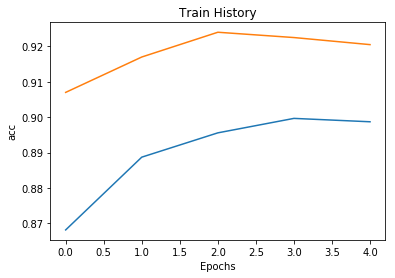

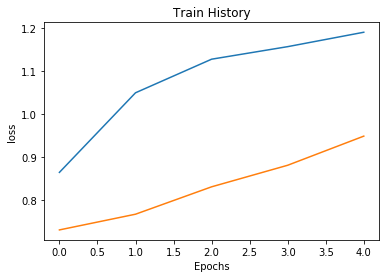

In [10]:
# 顯示每個 epoch 的 acc 與 val_acc 數據變化。
# acc 代表 model 對訓練資料的準確度，val_acc 代表 model 對驗證資料的準確度，
# val_acc 高比較好，如果跑完的結果 acc 高於 val_acc，那代表 Model 有 overfitting 的問題
show_train_history(train_history, "acc", "val_acc")

# 顯示每個 epoch 的 loss 與 val_loss 數據變化。
show_train_history(train_history, "loss", "val_loss")

# 驗證與測試

先拿驗證資料來看看判斷的準確性

In [11]:
batches, probs = vgg.test(valid_path, batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [12]:
filenames = batches.filenames
expected_labels = batches.classes
preds = probs[:, 0]
labels = np.round(1-preds)
print(labels)
print(expected_labels)

[ 0.  0.  0. ...,  1.  0.  1.]
[0 0 0 ..., 1 1 1]


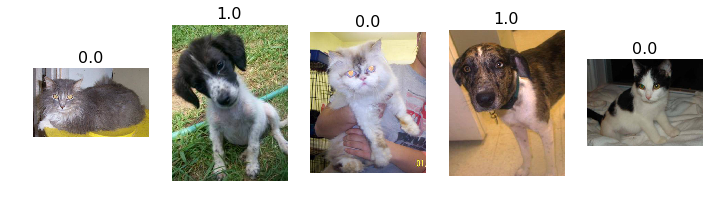

In [13]:
# 顯示正確判斷的圖片
correct = np.where(labels == expected_labels)[0]
plot_files(valid_path, correct, filenames, labels)

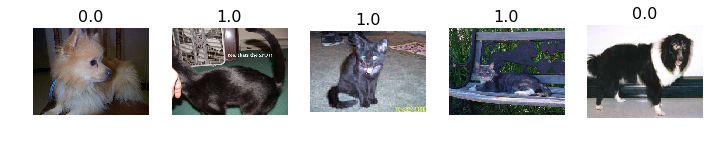

In [14]:
# 顯示錯誤判斷的圖片
incorrect = np.where(labels != expected_labels)[0]
plot_files(valid_path, incorrect, filenames, labels)

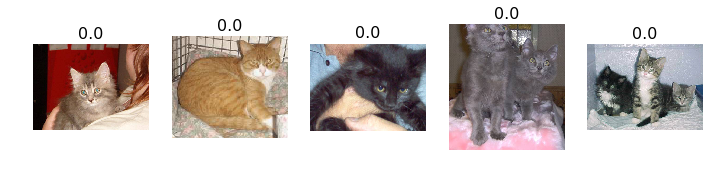

In [15]:
# 顯示正確判為貓咪的圖片
correct_cats = np.where((labels == expected_labels) & (labels == 0))[0]
plot_files(valid_path, correct_cats, filenames, labels)

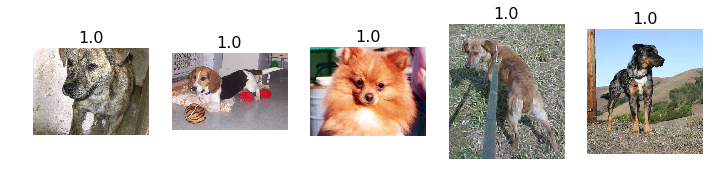

In [16]:
# 顯示正確判斷為狗狗的圖片
correct_dogs = np.where((labels == expected_labels) & (labels == 1))[0]
plot_files(valid_path, correct_dogs, filenames, labels)

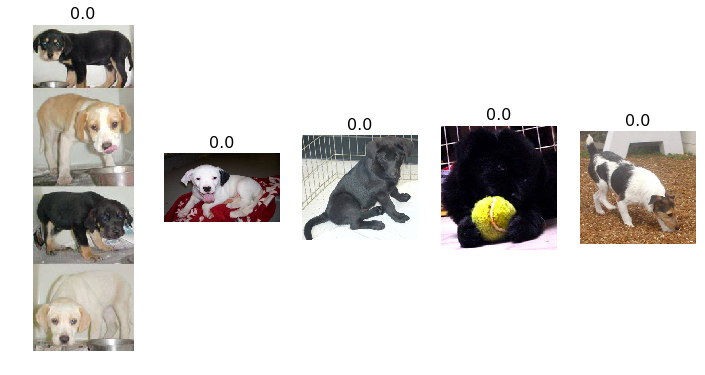

In [17]:
# 顯示貓咪誤判的圖片
incorrect_cats = np.where((labels != expected_labels) & (labels == 0))[0]
plot_files(valid_path, incorrect_cats, filenames, labels)

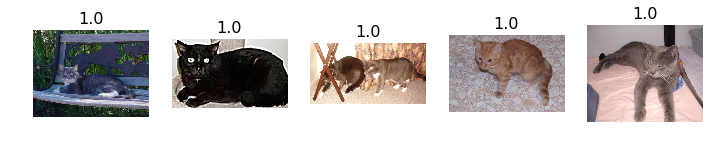

In [18]:
# 顯示狗狗誤判的圖片
incorrect_dogs = np.where((labels != expected_labels) & (labels == 1))[0]
plot_files(valid_path, incorrect_dogs, filenames, labels)

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, labels)

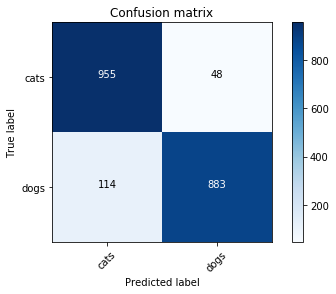

In [20]:
# 畫出混淆矩陣
plot_confusion_matrix(cm, batches.class_indices)

## 測試

In [21]:
# 對測試資料作測試
batches, probs = vgg.test(test_path, batch_size=batch_size)

Found 12500 images belonging to 1 classes.


In [22]:
np.set_printoptions(suppress=True, precision=4)
preds = probs[:,0]
labels = np.round(1-preds)

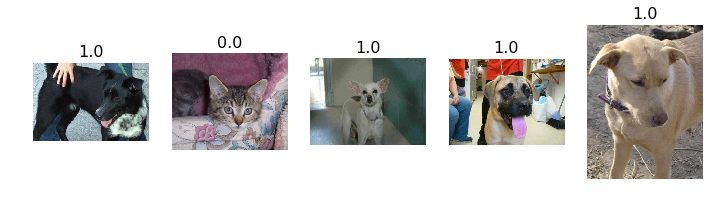

In [23]:
# 隨機抽樣五張照片檢視
random_idxs = np.random.choice(len(batches.filenames), 5)
plot_files(test_path, random_idxs, batches.filenames, labels)

# 準備上傳 Kaggle

Kaggle `dogs vs cats redux: kernel edition` 接受的資料格式是：
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

In [24]:
isdog = probs[:, 1]
print("Raw Predictions: " + str(isdog[:5]))
print("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [ 1.  0.  0.  1.  1.]
Mid Predictions: [ 0.5276  0.4962  0.4657  0.4368  0.5949  0.5524  0.436   0.5657  0.5546
  0.4186  0.4733  0.5079  0.4414  0.4333  0.5694  0.5114  0.5541  0.4373
  0.4349  0.4907  0.583   0.5309  0.4002  0.4829  0.5373  0.5345  0.4667
  0.5835  0.5597]
Edge Predictions: [ 1.  0.  1. ...,  1.  0.  0.]


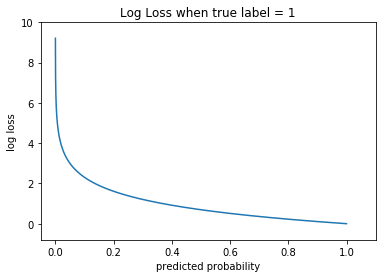

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1,0],[i*.0001,1-(i*.0001)],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [26]:
# 從上圖可知，log loss 在 probability 接近 0 時會飆高，因為競賽的分數是以 log loss 來看，所以對分數會不好
# 簡單的解法是將 0-1 的數值變化變成 0.05-0.95
isdog = isdog.clip(min=0.05, max=0.95)

In [27]:
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [28]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[   828.  ,      0.95],
       [ 10093.  ,      0.05],
       [  2205.  ,      0.05],
       [ 11812.  ,      0.95],
       [  4042.  ,      0.95]])

In [29]:
# 儲存每筆測試圖片的結果, 按照 Kaggle dogs vs cats 競賽所規定的儲存格式
%cd $DATA_HOME_PATH
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/paperspace/dogs-vs-cats-vgg16/data/redux


In [30]:
from IPython.display import FileLink
%cd $ROOT_PATH
FileLink("data/redux/" + submission_file_name)

/home/paperspace/dogs-vs-cats-vgg16


/home/paperspace/dogs-vs-cats-vgg16/data/redux/submission1.csv